<a href="https://colab.research.google.com/github/geo-yrao/ML4ES-tutorials/blob/master/NCICS_ML_lecture_08_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCICS ML Lesson 08: introduction to random forests and other decision tree ensemble methods

Welcome to Lesson 8 of the North Carolina Institute for Climate Studies' Machine Learning Course. In this session, we'll build upon the decision tree classification algorithms that we introduced in Lesson 7.

## Session purpose:
Introduce the general concept of ensemble classification methods, with an emphasis on two of the main tree ensemble methods.

## Session contents:
In this session, we will introduce you to both random forest classifiers and extreme gradient-boosted tree classifiers. They are both indispensible tools in a machine learning-practitioner's toolkit. Each of them, at their core, uses many decision trees to collectively construct their final classifiers; however, they go about constructing their classifiers in very different ways, as we covered in the lecture slides.

## About the data set:

The data set is actually satellite imagery of our home city of Asheville, taken from Landsat 8, an imaging satellite that was launched in 2013.  Check out the following links for more information:

[USGS Landsat Missions: Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)

[NASA Landsat Science: Landsat 8](https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/)

# Preprocess the data

We will be reusing the binary data set that we classified in Lesson 5. To prepare it for classification, we'll go through the same preprocessing steps as last time.

In [ ]:
# Import all of the libraries that we'll be using.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import xgboost as xgb

# Import additional modules, objects, and functions that we'll use.
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the path and names of our data files.
path_data_dir =\
  "./ML4ES-tutorials/00-Data/"
filename_data = "NC_L8_GroundTruth.csv"

# Clone the data from Douglas' repo and then check which files are present.
try:
    ! git clone https://github.com/geo-yrao/ML4ES-tutorials.git
    ! ls $path_data_dir
except:
    ! ls $path_data_dir

fatal: destination path 'ML4ES-tutorials' already exists and is not an empty directory.
CDL_2017.tif  label_information.txt  NC_L8_GroundTruth.csv  README.md


## Ingest the data 

Class label information:

1.   **Class 0**: forest (includes data from cdl classes: 'forest', 'deciduous forest', 'evergreen forest', 'mixed forest');
2.   **Class 1**: corn (includes data from cdl class 'corn');
3.   **Class 2**: soy (includes data from cdl class 'soybeans');
4.   **Class 3**: developed/urban (includes data from cdl classes 'developed/open space', 'developed/low intensity', 'developed/med intensity', 'developed/high intensity');
5.   **Class 4**: water (includes data from cdl class 'open water').

In [ ]:
# Use pandas's read_csv() function to import the data. Stipulate that the first column as the dataframe's index.
df_data = pd.read_csv(path_data_dir+filename_data, index_col=None)

# Delete the column named "Unnamed: 0", which were the row indices in the CSV.
df_data = df_data.drop(labels=["Unnamed: 0"], axis="columns")

# Isolate the data and the target values from the dataframe.
X = df_data.values[:, 3:]  # Data. The six L8 channels in the dataframe.
y = df_data.values[:, 2] # Target. The "class" column in the dataframe.
y_merged = np.array([i if i < 2 else i-1 for i in y]) # Merge corn and soy into single class.

# Define a list of the class names.
multiclass_labels_list = ["forest", "corn/soy", "urban", "water"]

## Random forest classifier: search for optimized hyperparameters

Here we will use a simple grid search to lightly optimize a random forest classifier.

In [ ]:
# Define the parameter ranges, over which the grid search algorithm will scan, 
# for the number of estimators (ie, the number of decision trees) in the random forest.
# We will try 25, 50, 100 and 200 trees.
N_ESTIMATORS = [25, 50, 100, 200,]

# Define the range of max tree depths over which to search. We will have the
# grid search check trees of depths 5, 10, 50 and also allow it to grow trees in
# an unrestrained manner. In scikit-learn, unrestrained tree growth is the
# default option and is indicated by including None as an argument.
MAX_DEPTH = [5, 10, 50, None]

# Take the two parameter lists we defined above and include them in a parameter
# grid that will be fed to scklearn's GridSearchCV object for hyperparameter
# optimization. See the following site for an example of such a parameter grid:
# https://scikit-learn.org/stable/modules/grid_search.html
# Know that the keywords of the parameter grid dictionaries are the names of the
# keyword arguments taken by the classifiers that we're optimizing.
param_grid = [
    {
        "n_estimators":N_ESTIMATORS,
        "max_depth":MAX_DEPTH,
    }
]

# Define a GridSearchCV object that will optimize a random forest classfier over
# our previously defined parameter grid. Set the grid search object to use 5-fold
# cross-validation and to take advantage of all of the available processors for
# running the search.
gridsearch_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv=5,
    n_jobs=-1,
)

# Run the search on the features and the merged classes.
gridsearch_rf.fit(X, y_merged)

# Print the best parameters from the grid search and the best score.
print("Best parameters:", gridsearch_rf.best_params_)
print("Best score:", gridsearch_rf.best_score_)

Best parameters: {'max_depth': 50, 'n_estimators': 200}
Best score: 0.8058947368421053


# XGBoost

Now we will run an analogous search for an XGBoost classifier instead.

In [ ]:
# Define a GridSearchCV object that takes an XGBoost classifier, instead of a
# random forest, as the model to optimize. Set that classifier's learning rate
# to 0.3, in order to match the default value for the R version of XGBoost 
# (neither Douglas nor I know the reason they have two distinct default learning
# rates).
gridsearch_xgb = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3),
    param_grid,
    cv=5,
    n_jobs=-1,
)

# Run the search on the features and the merged classes.
gridsearch_xgb.fit(X, y_merged)

# Print the best parameters from the grid search and the best score.
print("Best parameters:", gridsearch_xgb.best_params_)
print("Best score:", gridsearch_xgb.best_score_)

Best parameters: {'max_depth': 50, 'n_estimators': 100}
Best score: 0.8021052631578947


# Compare performance of RF and XGB

Here we will compare the performance of a random forest and an XGBoost classifier, using the best parameters found during the grid searches.

In [ ]:
# Initialize a random forest (RF) classifier object with the best hyperparameter 
# sets from the grid search.
rf_classifier = RandomForestClassifier(**gridsearch_rf.best_params_)

# Initialize an XGB classifier object with the best hyperparameter 
# sets from the grid search.
xgb_classifier = xgb.XGBClassifier(**gridsearch_xgb.best_params_)

# Initialize a stratified 5-fold cross-validation object.  Make certain that it
# randomly shuffles the data. AND, since it's randomly shuffling the data, make
# certain that its random state is set to 7 (an arbitrary choice: it simply
# needs to have a constant random state seed).
stratified_kfold_generator = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

# Iterate through each of the splits and train/test both classifiers. We will 
# store the predictions in the following lists, "classfication predictions_rf" 
# and "classfication predictions_xgb".
classification_predictions_rf = list()
classification_predictions_xgb = list()
for train, test in stratified_kfold_generator.split(X, y_merged):

    # Fit the classifiers to the training data. This erases the training from any
    # previous iteration of the loop.
    rf_classifier.fit(X[train], y_merged[train].ravel())
    xgb_classifier.fit(X[train], y_merged[train].ravel())

    # Have the newly trained classifiers predict the classes of the withheld testing data.
    y_predicted_rf = rf_classifier.predict(X[test])
    y_predicted_xgb = xgb_classifier.predict(X[test])

    # Add the true class labels and the predicted class labels to the storage lists.
    classification_predictions_rf.append((y_merged[test].ravel(), y_predicted_rf.ravel()))
    classification_predictions_xgb.append((y_merged[test].ravel(), y_predicted_xgb.ravel()))

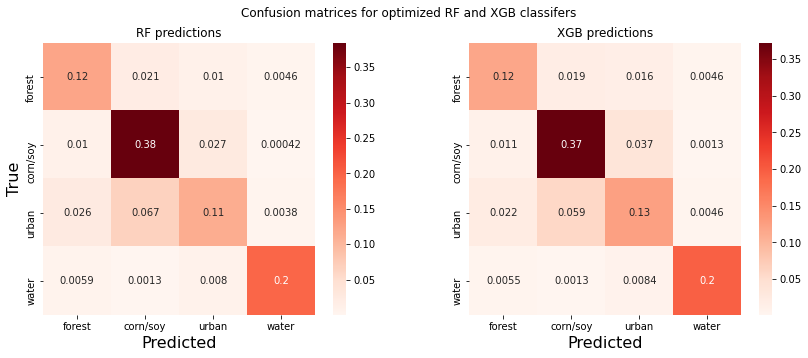

In [ ]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((4,4))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)
cf_xgb = calculate_normalized_conf_matrix(classification_predictions_xgb)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=multiclass_labels_list, yticklabels=multiclass_labels_list,
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("True", fontsize=16)

# Plot the XGBoost confusion matrix.
seaborn.heatmap(
    cf_xgb, cmap="Reds", annot=True, square=True,
    xticklabels=multiclass_labels_list, yticklabels=multiclass_labels_list,
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
ax[0].set_title("RF predictions")
ax[1].set_title("XGB predictions")

fig.suptitle("Confusion matrices for optimized RF and XGB classifers")

# Display the figure.
fig.show()